In [1]:
from iohblade.loggers import ExperimentLogger
from iohblade.plots import plot_convergence, plot_experiment_CEG, plot_boxplot_fitness_hue, plot_boxplot_fitness, fitness_table
import os

logger = ExperimentLogger('/home/neocortex/repos/BLADE/results/MABBOB_guided', True)
logger.add_read_dir('/home/neocortex/repos/BLADE/results/MABBOB_guided_baselines')
logger.add_read_dir('/home/neocortex/repos/BLADE/results/MABBOB_guided_baselines2')
log_data = logger.get_data()
log_data.head()

,method_name,problem_name,llm_name,method,problem,llm,solution,log_dir,seed
0,ES,MA_BBOB,gpt-5-mini-2025-08-07,"{'method_name': 'ES', 'budget': 200, 'kwargs':...","{'name': 'MA_BBOB', 'dims': [10], 'training_in...","{'model': 'gpt-5-mini-2025-08-07', 'code_patte...","{'id': '1075fb19-2d1a-4413-9005-a84684f12f29',...",run-ES-MA_BBOB-2,2
1,ES,MA_BBOB,gpt-5-mini-2025-08-07,"{'method_name': 'ES', 'budget': 200, 'kwargs':...","{'name': 'MA_BBOB', 'dims': [10], 'training_in...","{'model': 'gpt-5-mini-2025-08-07', 'code_patte...","{'id': '97b09f41-16dd-4b97-b046-9dcd1f56a34c',...",run-ES-MA_BBOB-1,1
2,ES,MA_BBOB,gpt-5-mini-2025-08-07,"{'method_name': 'ES', 'budget': 200, 'kwargs':...","{'name': 'MA_BBOB', 'dims': [10], 'training_in...","{'model': 'gpt-5-mini-2025-08-07', 'code_patte...","{'id': '008715f8-d903-40a3-b331-ffbbeff335d1',...",run-ES-MA_BBOB-5,5
3,ES,MA_BBOB,gpt-5-mini-2025-08-07,"{'method_name': 'ES', 'budget': 200, 'kwargs':...","{'name': 'MA_BBOB', 'dims': [10], 'training_in...","{'model': 'gpt-5-mini-2025-08-07', 'code_patte...","{'id': '2a2b9226-c20f-44ac-95be-b81a5536bba3',...",run-ES-MA_BBOB-3,3
4,ES,MA_BBOB,gpt-5-mini-2025-08-07,"{'method_name': 'ES', 'budget': 200, 'kwargs':...","{'name': 'MA_BBOB', 'dims': [10], 'training_in...","{'model': 'gpt-5-mini-2025-08-07', 'code_patte...","{'id': '79bbe510-8d01-4e86-bb38-258c33bcbd1d',...",run-ES-MA_BBOB-4,4


In [2]:
methods, problems = logger.get_methods_problems()
print(methods)
print(problems)

['MCTS_AHD', 'LHNS:vns', 'ES (gemini)', 'ES', 'ES-guided (gemini)', 'ES-guided']
['MA_BBOB']


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
"""Simple runner to analyze generated algorithms one by one on a wide benchmark set
"""
from ioh import get_problem, logger,LogInfo
import re
import os
import ioh
from tqdm.notebook import tqdm
from iohblade.utils import OverBudgetException
from iohblade.utils import budget_logger
import numpy as np

#load MA_BBOB files
weights = pd.read_csv(
    os.path.join("/home/neocortex/repos/BLADE/iohblade/problems/mabbob", "weights.csv"), index_col=0
)
iids = pd.read_csv(
    os.path.join("/home/neocortex/repos/BLADE/iohblade/problems/mabbob", "iids.csv"), index_col=0
)
opt_locs = pd.read_csv(
    os.path.join("/home/neocortex/repos/BLADE/iohblade/problems/mabbob", "opt_locs.csv"), index_col=0
)

In [ ]:
# now we evaluate all best solutions using IOH

"""Simple runner to analyze generated algorithms one by one on a wide benchmark set
"""
exp_data = log_data.copy()
if 'fitness' not in log_data.columns:
    exp_data['fitness'] = exp_data['solution'].apply(lambda sol: sol.get('fitness', float('nan')))

exp_data['fitness'].replace(float('-inf'), 0.0, inplace=True)

exp_data["fitness"] = exp_data["fitness"].replace("-inf", 0.0)
#print(exp_data["fitness"])
# Group by (problem_name, method_name) and find the row with the best (lowest) fitness
best_rows = exp_data.loc[exp_data.groupby(['problem_name', 'method_name'])['fitness'].idxmax()]

for idx, row in best_rows.iterrows():

    if "gemini" in row['method_name']:
        continue
    
    solution_dict = row['solution']
    method_name = row['method_name']
    problem_name = row['problem_name']
    fitness = row['fitness']

    #algorithm_name = re.findall("try-\d*-(\w*)\.py", code_file, re.IGNORECASE)[0]
    algorithm_name = solution_dict["name"]
    alg = solution_dict["code"]
    print("Benchmarking", algorithm_name)

    for dim in [5]:
        budget = 2000 * dim
        
        loggers = [budget_logger(budget=budget, triggers=[logger.trigger.ALWAYS]), logger.Analyzer(folder_name=f"../results/ioh-MABBOB-guided/{method_name}", algorithm_name=method_name)]
        l1 = logger.Combine(loggers)

        for iid in tqdm(range(100, 150)):
            problem = ioh.problem.ManyAffine(
                xopt=np.array(opt_locs.iloc[iid])[:dim],
                weights=np.array(weights.iloc[iid]),
                instances=np.array(iids.iloc[iid], dtype=int),
                n_variables=dim,
            )
            problem.set_id(100)
            problem.set_instance(iid)
            problem.attach_logger(l1)
            for rep in range(5):
                np.random.seed(rep)
                try:
                    safe_globals = {"np": np}
                    local_env = {}
                    exec(alg, safe_globals, local_env)
                    algorithm = local_env[algorithm_name](budget=budget, dim=dim)
                    algorithm(problem)
                except OverBudgetException:
                    pass
                except Exception:
                    pass
                problem.reset()
    with open(f'../results/ioh-MABBOB-guided/{method_name}.py', 'w', encoding='utf-8') as f:
        f.write(alg)



Benchmarking DARESv2_Plus


/tmp/ipykernel_2513396/1844319225.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  exp_data['fitness'].replace(float('-inf'), 0.0, inplace=True)
/tmp/ipykernel_2513396/1844319225.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  exp_data["fitness"] = exp_data["fitness"].replace("-inf", 0.0)


  0%|          | 0/50 [00:00<?, ?it/s]

<string>:454: RuntimeWarning: divide by zero encountered in divide
<string>:461: RuntimeWarning: invalid value encountered in multiply


Benchmarking EntropyBoostedSubspaceAdaptiveSearch


  0%|          | 0/50 [00:00<?, ?it/s]

Benchmarking AdaptiveSubspaceCovarianceSearch


  0%|          | 0/50 [00:00<?, ?it/s]

Benchmarking MirrorAdaptiveDECovInject


  0%|          | 0/50 [00:00<?, ?it/s]

In [24]:

#!pip install polars iohinspector
import iohinspector
import polars as pl
manager = iohinspector.DataManager()
#manager.add_folder("../results/ioh-MABBOB")
manager.add_folder("../results/ioh-MABBOB-guided")
df = manager.load(True, True)



/home/neocortex/repos/BLADE/.venv/lib/python3.11/site-packages/iohinspector/align.py:109: UserWarning: Sortedness of columns cannot be checked when 'by' groups provided
  result_df = x_vals.join_asof(


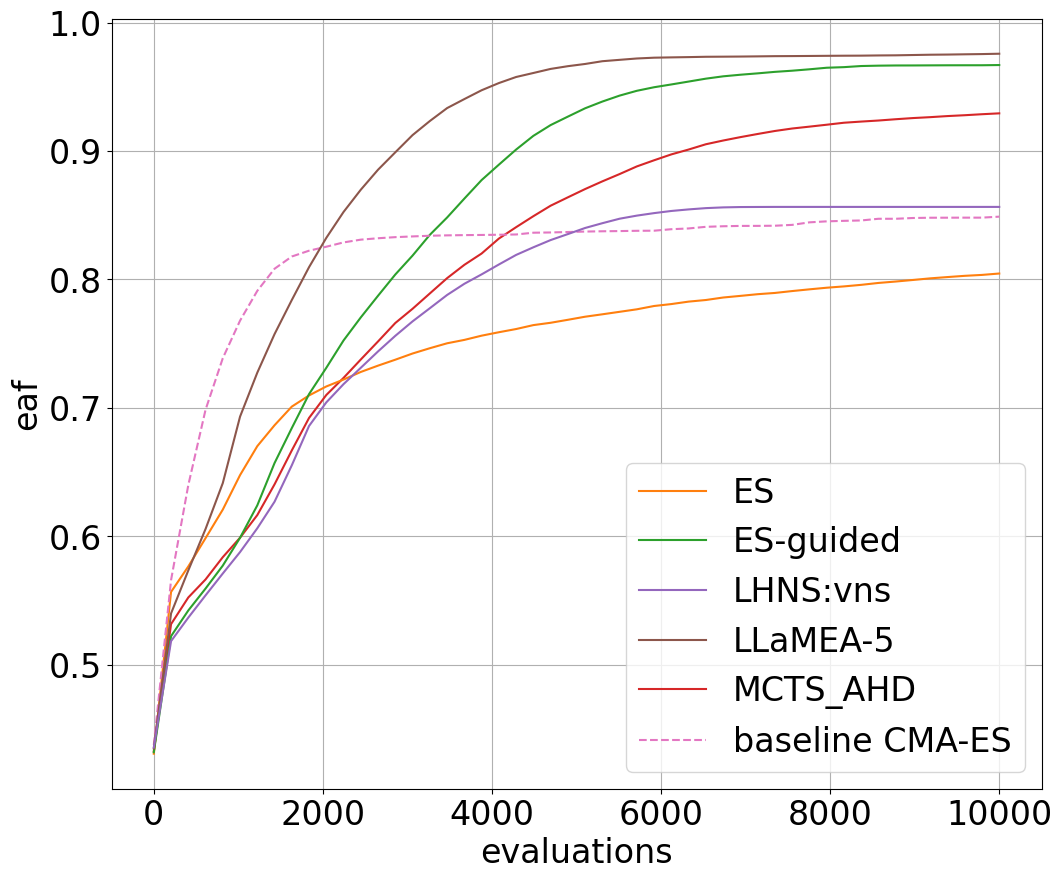

In [25]:
import operator
custom_color_map = {
    "LLaMEA-5" :"C5",
    "baseline CMA-ES" :"C6",
    'MCTS_AHD': "C3", 
    'LHNS:vns': "C4",
    'ES': "C1",
    'ES-guided': "C2"
    # etc.
}

fig, ax = plt.subplots(1,1, figsize=(12,10))
_ = iohinspector.plot.plot_ecdf(df.filter(pl.col("dimension") == 5), y_max=100, y_min=1e-8, ax=ax, scale_xlog=False)
# Get the current legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Also get the lines (the actual plot objects) in the order they were created.
# Usually, ax.lines matches up with the unique hue levels in the same order
lines = ax.lines

# Make a mapping from label -> line object
label_to_line = dict(zip(labels, lines))

for handle, label in zip(handles, labels):
    # For bar charts, the handles are Rectangle patches
    handle.set_color(custom_color_map[label])
    if label == "baseline CMA-ES":
        handle.set_linestyle("--")
    else:
        handle.set_linestyle("-")
    if label == "LLaMEA-5":
        handle.set_label("Winner MA-BBOB 2025")

for label, line in label_to_line.items():
    # Set the color/linestyle on the actual plot line
    line.set_color(custom_color_map.get(label, 'black'))
    if label == "baseline CMA-ES":
        line.set_linestyle("--")
    else:
        line.set_linestyle("-")

# Sort them alphabetically (by label)
sorted_pairs = sorted(zip(labels, handles), key=operator.itemgetter(0))
sorted_labels, sorted_handles = zip(*sorted_pairs)

# Clear the old legend and create a new one in sorted order
ax.legend(sorted_handles, sorted_labels)
plt.show()

In [14]:
df_eaf = iohinspector.metrics.transform_fval(df, 1e-8, 1e2)
iohinspector.metrics.get_aocc(df_eaf.filter(pl.col("dimension") == 5), 10000, group_cols=['algorithm_name'])

algorithm_name,AOCC
str,f64
"""baseline CMA-ES""",0.70778
"""LLaMEA-4""",0.717198
"""LLaMEA-2""",0.759521
"""LLaMEA-1""",0.698703
"""LLaMEA-3""",0.742359
"""LLaMEA-5""",0.837403


<Figure size 1200x700 with 0 Axes>

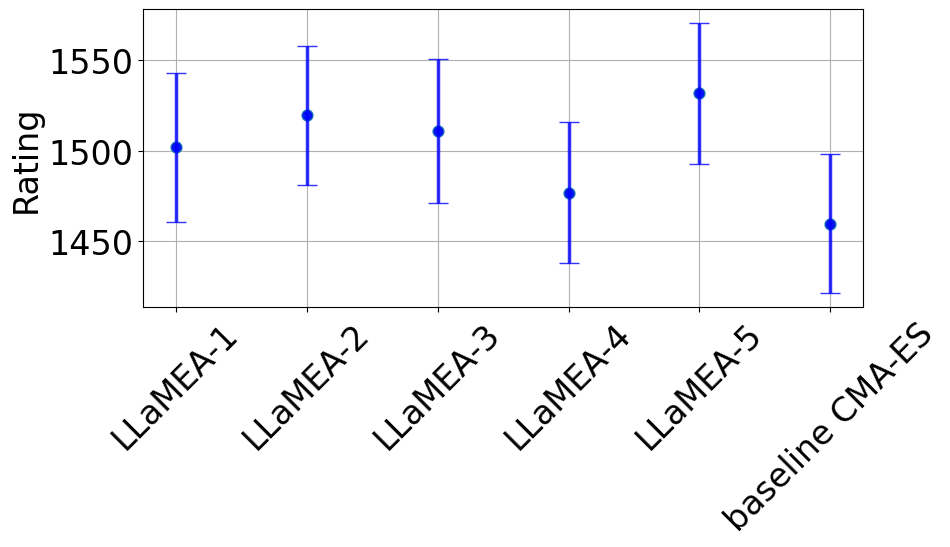

In [10]:
_, ax = plt.subplots(1, 1, figsize=(12, 7))
dt_elo = iohinspector.plot.plot_tournament_ranking(df, nrounds=100000, ax=ax)
dt_elo_sorted = dt_elo.sort_values(by='algorithm_name')
plt.clf()
_, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.pointplot(data=dt_elo_sorted, x="algorithm_name", y="Rating", linestyle="none", ax=ax)

ax.errorbar(
    dt_elo_sorted["algorithm_name"],
    dt_elo_sorted["Rating"],
    yerr=dt_elo_sorted["Deviation"],
    fmt="o",
    color="blue",
    alpha=0.8,
    capsize=7,
    elinewidth=2.5,
)
ax.grid()

ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("")
plt.tight_layout()
plt.savefig("MA_BBOB-elo.png")